# Branching DQN with Pendulum Continous - Solution
22.03.2022, Gruppe A

Reference:
https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py

## Aufgaben
1. Beheben Sie den Fehler in der BranchingQNetwork-Klasse (Netzwerk)
2. Sorgen Sie dafür das der Learning-Rate Parameter im AgentConfig auch angewandt wird
3. Kontrolliere die Reihenfolge von `loss.backward`, `adam.zero_grad` und `adam.step`. Bringe sie in die richtige Reihenfolge. Bei Pointer `### AUFGABE 3 ###` bis `### AUFGABE 3 Ende ###`
4. Wofür verwendet man `bins` und wo werden diese definiert?
5. Wie sieht die Einteilung die diskrete Einteilung des Action-Space aus? (Als Array)
6. Visualisieren Sie den Reward in Abhängigkeit der Frames(Episoden), mit 10_000 Frames

> Lösungen siehe mit FIX markierte Stellen

In [1]:
import collections
import random
import numpy as np

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
class ExperienceReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        for b in batch:
            states.append(b[0])
            actions.append(b[1])
            rewards.append(b[2])
            next_states.append(b[3])
            dones.append(b[4])
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

In [3]:
class BranchingQNetwork(nn.Module):                 # Agent
    def __init__(self,
                 obs,                               # observations
                 ac_dim, n):                        # continous actions auf n sections discretisiert
        super().__init__()
        self.ac_dim = ac_dim
        self.n = n
        self.model = nn.Sequential(
            nn.Linear(obs, 128),                    # Input = Observations
            nn.ReLU(),
            nn.Linear(128,128),                     # FIX 128 anstelle 128
            nn.ReLU() )
        self.value_head = nn.Linear(128, 1)         # Value State
                                                    # Advantage pro Action
        self.adv_heads = nn.ModuleList([nn.Linear(128, n) for i in range(ac_dim)])

    def forward(self, x):
        out = self.model(x)

        value = self.value_head(out)
        advs = torch.stack([l(out) for l in self.adv_heads], dim = 1)

        q_val = value.unsqueeze(2) + advs - advs.mean(2, keepdim = True )
        return q_val


    def update_model(self, other_model, tau=None):
        """Updates the model weigths, either 1:1 if tau is None or weighted with tau [0.0 - 1.0).
        The weighted update follows the following logic for model weights
        but is adapted for the model.state_dict parameters:
            new_target_weights = []
            for target, online in zip(self.model.get_weights(), other_model.model.get_weights()):
                target_ratio = (1.0 - self.tau) * target            # target_model (self)
                online_ratio = self.tau * online                    # online_model (other_model)
                mixed_weights = target_ratio + online_ratio
                new_target_weights.append(mixed_weights)
            self.model.set_weights(new_target_weights)
        """

        # standard update without weights
        if tau is None:
            self.load_state_dict( other_model.state_dict() )
            return

        for target_param, local_param in zip(other_model.parameters(), self.parameters()):
          target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [4]:
class AgentConfig:
    def __init__(self,
                 epsilon_start = 1.,
                 epsilon_final = 0.01,
                 epsilon_decay = 800,               # Orig=8000
                 gamma = 0.99,
                 lr = 1e-4,
                 target_net_update_tau = 0.3,       # Orig=None, changed for weighted update to 0.1 [0.0. ... 1.0]
                 target_net_update_freq = 300,      # Orig=1000, changed for weighted update to 100
                 memory_size = 100000,
                 batch_size = 128,
                 learning_starts = 5000,
                 max_frames = 10_000):
        self.epsilon_start = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay
        self.epsilon_by_frame = lambda i: self.epsilon_final + (self.epsilon_start - self.epsilon_final) * np.exp(-1. * i / self.epsilon_decay)
        # gamma and learining rate
        self.gamma =gamma
        self.lr = lr                                # FIX: Zuweisung lr anstelle 1000
        # update frequency, memory and batch size
        self.target_net_update_tau = target_net_update_tau
        self.target_net_update_freq = target_net_update_freq
        self.memory_size =memory_size
        self.batch_size =batch_size
        # initialize lr and frames
        self.learning_starts = learning_starts
        self.max_frames = max_frames


In [5]:
class BranchingDQNAgent(nn.Module):
    def __init__(self, obs, ac, n, config):
        super().__init__()
        # Model
        self.q = BranchingQNetwork(obs, ac,n )
        self.target = BranchingQNetwork(obs, ac,n )
        # self.target.load_state_dict(self.q.state_dict())
        self.target.update_model(self.q, tau=None)
        # Model update parameters
        self.target_net_update_tau = config.target_net_update_tau
        self.target_net_update_freq = config.target_net_update_freq
        self.update_counter = 0

    def get_action(self, x): 
        with torch.no_grad():
            # a = self.q(x).max(1)[1]
            out = self.q(x).squeeze(0)                  # Beispiel
            action = torch.argmax(out, dim = 1)         # Tensor(4) [1,0,3,3] = 4 Aktionen, A1=Bin 1, A2=Bin 0, A3=Bin 3, A4=Bin 3
        return action.numpy()

    def update_policy(self, adam, memory, params): 
        b_states, b_actions, b_rewards, b_next_states, b_masks = memory.sample(params.batch_size)
        states = torch.tensor(b_states).float()
        actions = torch.tensor(b_actions).long().reshape(states.shape[0],-1,1)
        rewards = torch.tensor(b_rewards).float().reshape(-1,1)
        next_states = torch.tensor(b_next_states).float()
        masks = torch.tensor(b_masks).float().reshape(-1,1)

        # Gather: Extraktion Q-Values für Aktionen (Index 2 = dritte Position = continous values)
        # - self.q(states)   = Tensor(128,4,6) wobei 4 Actions mit 6 continous values
        # - actions          = Tensor(128,4,1) wobei 4 Actions mit 6 discrete values (bin nummer 0..5), squeeze letzte dim weg nehmen
        # - current_q_values = Tensor(128,4)   wobei 4 Actions mit 6 continous values
        current_q_values = self.q(states).gather(2, actions).squeeze(-1)        # 128, 4

        with torch.no_grad():
            argmax = torch.argmax(self.q(next_states), dim = 2)
            # Target ist zuständig für nächsten State, Online zuständig für aktuellen State
            max_next_q_vals = self.target(next_states).gather(2, argmax.unsqueeze(2)).squeeze(-1)
            # Original
            # max_next_q_vals = max_next_q_vals.mean(1, keepdim = True)
            max_next_q_vals = max_next_q_vals.mean(1, keepdim = True).expand(-1,1) # max_next_q_vals.shape[1]) # Expand to 128,2 (Actions)

        expected_q_vals = rewards + max_next_q_vals*0.99*masks
        loss = F.mse_loss(expected_q_vals, current_q_values)
        ### AUFGABE 3 ###
        adam.zero_grad()                            # FIX: Zuerste zero_grad, dann backward
        loss.backward()                             # Backward Step mit Gradienten Berechnen (Werte ändern)
        
        for p in self.q.parameters():               # Begrenzung Gradienten auf -1 .. 1
            p.grad.data.clamp_(-1.,1.)
        adam.step()
        ### AUFGABE 3 ENDE ###

        self.update_counter += 1
        if self.update_counter % self.target_net_update_freq == 0: 
            self.update_counter = 0
            # weighted update
            # self.target.load_state_dict(self.q.state_dict())
            self.target.update_model(self.q, self.target_net_update_tau)

In [8]:
class TensorEnv(gym.Wrapper):
    def __init__(self, env_name):
        super().__init__(gym.make(env_name))

    def process(self, x):
        return torch.tensor(x).reshape(1,-1).float()

    def reset(self):
        return self.process(super().reset())

    def step(self, a):
        ns, r, done, infos = super().step(a)
        return self.process(ns), r, done, infos


class BranchingTensorEnv(TensorEnv):
    def __init__(self, env_name, n):
        super().__init__(env_name)
        self.n = n
        self.discretized = np.linspace(max(self.action_space.low),max(self.action_space.high), self.n)    # bins=8, aus countinous action werden 6 bins gemacht
        print("Discretiezed action space:")
        print(self.discretized)
        # FIX: Output
        # Discretiezed action space:
        # [-2. -1.42857143 -0.85714286 -0.28571429  0.28571429  0.85714286 1.42857143  2.]

    def step(self, a):
        # aus 4 actions werden die diskretisierten Werte erstellt anhand
        action = np.array([self.discretized[aa] for aa in a])
        return super().step(action)

In [22]:
# Discretization of continous action space to linespace with n bins
bins = 8                                        # FIX: Unterteilung Continous Space in Behälter
                                                # sonst können keine Erfahrungen gesammelt werden
                                                # da es zu viele Möglichkeiten gibt!
env = BranchingTensorEnv('Pendulum-v0', bins)

# Initialize Agent (with Branching-Q-Network and Target-Branching-Q-Network), Memory and Optimizer
config = AgentConfig()
agent = BranchingDQNAgent(env.observation_space.shape[0], env.action_space.shape[0], bins, config)
memory = ExperienceReplayMemory(config.memory_size)
optimizer = optim.Adam(agent.q.parameters(), lr = config.lr)

s = env.reset()
ep_reward = 0.
recap = []

rewards = []

p_bar = tqdm(total = config.max_frames)
for frame in range(config.max_frames):

    epsilon = config.epsilon_by_frame(frame)

    if np.random.random() > epsilon:
        action = agent.get_action(s)
    else:
        action = np.random.randint(0, bins, size = env.action_space.shape[0])

    ns, r, done, infos = env.step(action)
    ep_reward += r

    rewards.append(r)

    if done:
        ns = env.reset()
        recap.append(ep_reward)
        p_bar.set_description('Rew: {:.3f}'.format(ep_reward))
        ep_reward = 0.

    # Umwandlung zu listen
    memory.push((s.reshape(-1).numpy().tolist(), action, r, ns.reshape(-1).numpy().tolist(), 0. if done else 1.))
    s = ns

    p_bar.update(1)

    if frame > config.learning_starts:
        agent.update_policy(optimizer, memory, config)


p_bar.close()


Discretiezed action space:
[-2.         -1.42857143 -0.85714286 -0.28571429  0.28571429  0.85714286
  1.42857143  2.        ]


Rew: -1265.964: 100%|██████████| 10000/10000 [00:17<00:00, 572.56it/s]



#
# RECAP
#
50
[-1345.5701623706927, -1367.1636774720378, -1440.8254221359134, -1549.1583403123932, -1587.3614097545146, -1662.3527598945402, -1408.3031674671397, -1675.9531465733173, -1423.9669455589456, -1620.890068152234, -1578.8518013071155, -1713.6411867460683, -1709.5238765307922, -1426.183654722818, -1598.7163174136072, -1645.6322957890945, -1662.0952635858662, -1699.204428611385, -1681.355463898628, -1714.4110711530227, -1629.3487718215526, -1678.17486135006, -1671.860968597992, -1502.9283806109747, -1588.301463297432, -1532.5063361750456, -1720.3647512057532, -1629.3294072610638, -1612.4487524723052, -1196.9142580553867, -1829.531405063049, -1484.1110917658586, -1663.813126338537, -1456.9755967334756, -1124.3631022574498, -1242.1031329371683, -1232.5615185288927, -968.0975380310836, -1298.5395900850147, -1265.2577513290544, -934.7164665530955, -1152.265521343317, -928.4281702691077, -949.4286418940079, -899.468031715991, -1189.0736039666133, -1580.606213121579, -588.938480925

Text(0.5, 1.0, 'Branching DDQN: Pendulum-v0')

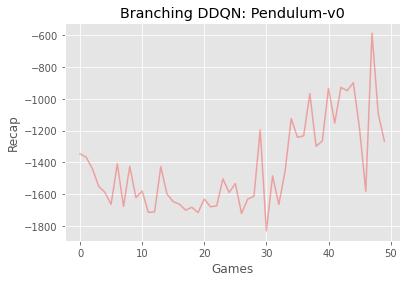

In [23]:
print("")
print("#")
print("# RECAP")
print("#")
print(len(recap))
print(recap)

# plot
plt.cla()
plt.plot(recap, c = 'r', alpha = 0.3)
# plt.plot(gaussian_filter1d(rewards, sigma = 5), c = 'r', label = 'Rewards')
plt.xlabel('Games')
plt.ylabel('Recap')
plt.title('Branching DDQN: {}'.format('Pendulum-v0'))


#
# REWARDS
#
len: 10000
min: -16.247174892486935
max: -0.004854219812457094
rewards: [-3.7764965627917104, -3.8907585124743633, -4.404427492921528, -4.926864903301255, -5.926830567797489, -7.176372459785102, -8.397933011707872, -9.781678403232133, -11.302436669632412, -11.049236039405695, -9.743079963584949, -8.273526278497732, -7.082520672684475, -5.91259375613934, -5.015003888186773, -4.323872041078109, -3.713162239347384, -3.2794046247596076, -3.0664745204921506, -3.0370309180192225, -3.152778298909976, -3.5273414142837636, -4.124697417009787, -5.152779382563503, -6.630749326236532, -8.014849150695984, -9.829466471848086, -11.22304483226427, -12.098304121482219, -10.663066261607963, -9.043240412382044, -7.682706650885217, -6.316646834314787, -4.769872731088478, -3.624486881419027, -2.9242847601015005, -2.555040017709835, -2.3045951213408506, -2.2359262169421545, -2.4190068439775847, -2.782814920582514, -3.547397467904768, -4.418248376444688, -5.754773136208575, -7.435053140249285, 

Text(0.5, 1.0, 'Branching DDQN: Pendulum-v0')

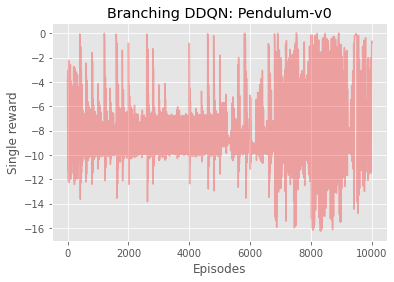

In [24]:
print("#")
print("# REWARDS")
print("#")
print("len:", len(rewards))
print("min:", min(rewards))
print("max:", max(rewards))
print("rewards:", rewards)


# plot
plt.cla()
plt.plot(rewards, c = 'r', alpha = 0.3)
# plt.plot(gaussian_filter1d(rewards, sigma = 5), c = 'r', label = 'Rewards')
plt.xlabel('Episodes')
plt.ylabel('Single reward')
plt.title('Branching DDQN: {}'.format('Pendulum-v0'))
